In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

# 1. X-y split

In [58]:
from scipy.stats import zscore

In [59]:
# filter the dataframe to remove the outliers
def remove_outliers(num_df):
    z = num_df.apply(zscore)
    threshold = 3
    num_df = num_df[(z < threshold).all(axis=1)]
    return num_df

In [60]:
# load the data with dummies and ordinally encoded categorical data and then load the numerical data
# define numerical and categorical Xs and target feature y

X = pd.read_csv("Data_Marketing_Customer_Analysis_Round3.csv")
categoricalX = X.select_dtypes(object).drop("effective_to_date",axis=1)

categoricalX = pd.read_csv("dum_df.csv")

numericalX = pd.read_csv("num_df.csv")
y = numericalX["total_claim_amount"]
numericalX = numericalX.drop("total_claim_amount", axis=1)

X = pd.concat([categoricalX, numericalX], axis=1)

In [61]:
X.isna().any()
# no need to drop anything

coverage                         False
education                        False
vehicle_size                     False
east                             False
north west                       False
west region                      False
yes                              False
jan                              False
employed                         False
medical leave                    False
retired                          False
unemployed                       False
m                                False
suburban                         False
urban                            False
married                          False
single                           False
personal auto                    False
special auto                     False
corporate l2                     False
corporate l3                     False
personal l1                      False
personal l2                      False
personal l3                      False
special l1                       False
special l2               

# 2. Test - train split

In [62]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [63]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
X_train.head(10)

,coverage,education,vehicle_size,east,north west,west region,yes,jan,employed,medical leave,...,sports car,suv,two-door car,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
2705,0,1,1,0,0,0,0,1,1,0,...,0,0,0,4786,45515,61,10,33,0,9
2209,0,1,1,0,0,0,0,0,0,0,...,0,0,0,22445,80340,71,32,35,0,2
4004,1,1,1,0,0,1,0,1,1,0,...,0,0,0,6412,58776,83,20,50,2,4
1898,0,1,1,1,0,0,0,1,0,0,...,0,0,0,2254,48978,65,7,95,0,1
10016,1,1,1,0,0,1,0,1,1,0,...,0,0,1,7427,28848,96,22,54,0,7
3098,0,1,0,0,0,1,0,1,1,0,...,0,0,1,7579,33906,64,25,49,0,2
1327,1,0,1,0,0,1,0,0,1,0,...,0,0,0,3399,28928,87,23,7,1,1
7903,1,1,1,1,0,0,0,1,1,0,...,0,1,0,10990,44552,137,7,42,0,3
7108,0,0,1,0,1,0,0,1,1,0,...,0,1,0,12375,78441,103,6,73,0,2
5142,0,0,1,0,0,1,1,1,1,0,...,0,0,0,5639,73168,70,21,50,0,3


# 3. Standardize data

In [64]:
from sklearn.preprocessing import StandardScaler

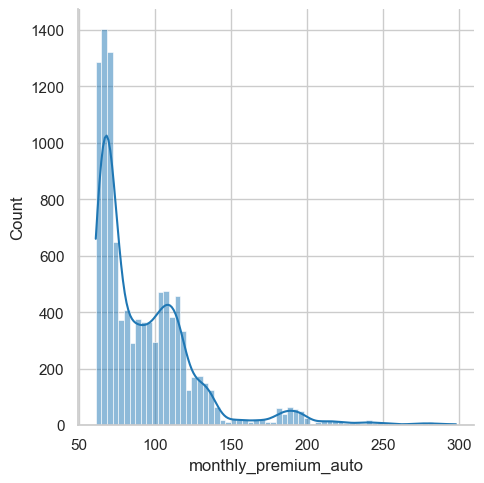

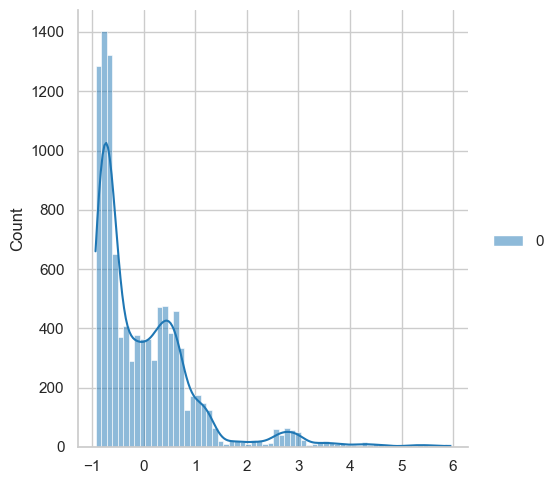

In [65]:
# apply the StandardScaler to scale the distributions
ss = StandardScaler()
monthly_premium_transformed = ss.fit_transform(numericalX["monthly_premium_auto"].to_numpy().reshape(-1,1))

# original distribution
sns.displot(numericalX["monthly_premium_auto"], kde=1)
# normalized distribution done with StandardScaler
sns.displot(monthly_premium_transformed, kde=1)

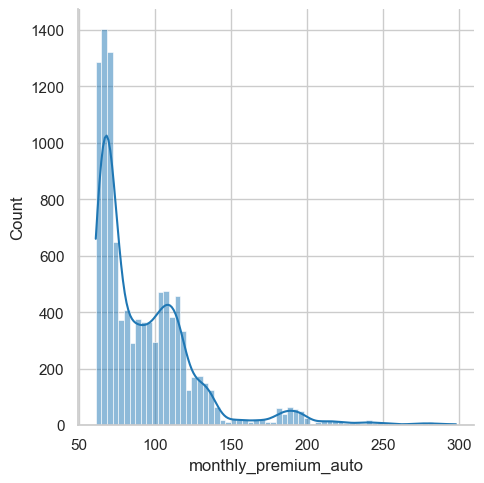

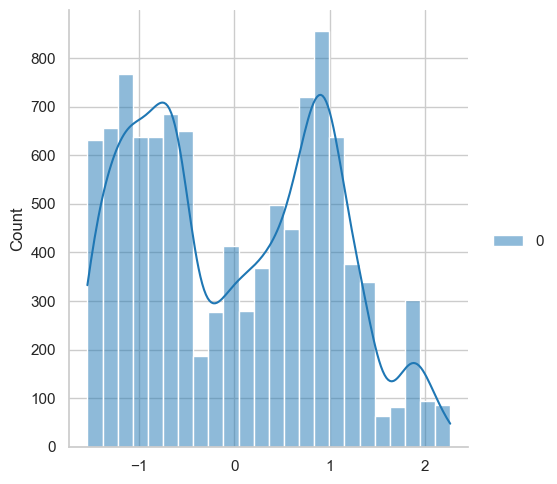

In [66]:
# apply the PowerTransformer to scale the distributions
pt = PowerTransformer()
monthly_premium_transformed = pt.fit_transform(numericalX['monthly_premium_auto'].to_numpy().reshape(-1,1))

# original distribution
sns.displot(numericalX["monthly_premium_auto"], kde=1)
# normalized and normally transformed distribution done with PowerTransform
sns.displot(monthly_premium_transformed, kde=1)

In [67]:
print("the parameters used to transform monthly_premium_transformed (pt) are", pt.get_params(), "\nlambdas:" , pt.lambdas_)
# parameter used in the power transformation

print("the parameters used to transform monthly_premium_transformed (ss) are", ss.get_params())

the parameters used to transform monthly_premium_transformed (pt) are {'copy': True, 'method': 'yeo-johnson', 'standardize': True} 
lambdas: [-1.48520773]
the parameters used to transform monthly_premium_transformed (ss) are {'copy': True, 'with_mean': True, 'with_std': True}


In [68]:
X.columns

Index(['coverage', 'education', 'vehicle_size', 'east', 'north west',
       'west region', 'yes', 'jan', 'employed', 'medical leave', 'retired',
       'unemployed', 'm', 'suburban', 'urban', 'married', 'single',
       'personal auto', 'special auto', 'corporate l2', 'corporate l3',
       'personal l1', 'personal l2', 'personal l3', 'special l1', 'special l2',
       'special l3', 'offer2', 'offer3', 'offer4', 'branch', 'call center',
       'web', 'luxury car', 'luxury suv', 'sports car', 'suv', 'two-door car',
       'customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies'],
      dtype='object')

In [69]:
ss = ColumnTransformer([("ss", ss, list(X.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ss = pd.DataFrame(ss.transform(X_train), columns=ss.get_feature_names_out())
X_test_ss = pd.DataFrame(ss.transform(X_test), columns=ss.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s


In [70]:
# using the ColumnTransformer to transform the numerical columns with the PowerTransformer
ct = ColumnTransformer([("pt", pt, list(X.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.6s


# 4. Apply linear regression

## 4.1 OLS

### StandardScaler model

In [71]:
X_train_const_ss = sm.add_constant(X_train_ss.to_numpy()) # adding a constant

model_ss = sm.OLS(y_train, X_train_const_ss).fit()
# predictions_train = model.predict(X_train_const_ct)

X_test_const_ss = sm.add_constant(X_test_ss) # adding a constant
predictions_test = model_ss.predict(X_test_const_ss)
print_model = model_ss.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     592.5
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:35:20   Log-Likelihood:                -47508.
No. Observations:                7482   AIC:                         9.510e+04
Df Residuals:                    7438   BIC:                         9.541e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.8295      1.606    271.422      0.0

In [72]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model_ct = sm.OLS(y_train, X_train_const_ct).fit()
# predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model_ct.predict(X_test_const_ct)
print_model = model_ct.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     491.0
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:35:20   Log-Likelihood:                -48041.
No. Observations:                7482   AIC:                         9.617e+04
Df Residuals:                    7438   BIC:                         9.647e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.8295      1.724    252.786      0.0

## 3.2 SciKit Learn

In [73]:
# standard scaled train set
model_ss=LinearRegression()    # model
model_ss.fit(X_train_ss, y_train)   # model train

LinearRegression()

In [74]:
# power transformed train set
model_ct=LinearRegression()    # model
model_ct.fit(X_train_ct, y_train)   # model train

LinearRegression()

# 5. Model interpretation

In [75]:
print(model_ss.coef_, "\n", model_ct.coef_)

[[-8.54039051e+00 -7.17641984e+00 -4.07978965e-01  1.02890732e+00
  -2.26198866e-01  1.61302026e+00 -8.17459415e+00 -1.23520687e+00
  -2.93097524e+00  3.95269232e+00 -9.95658497e-01  3.69956118e+01
   8.73198295e+00  1.82704481e+02  8.31257047e+01 -2.15974275e+00
   2.74800037e+01  1.75382461e+13 -4.25127123e+12 -3.00507309e+00
  -4.96310916e-01 -1.38758716e+13 -1.69382439e+13 -1.94859697e+13
   1.88975235e+12  2.81267656e+12  2.66187129e+12  7.60490308e+00
   2.76011799e+00  2.31539255e+00 -8.53018643e-01 -2.75731617e-01
  -1.31273413e+00  2.72509709e+00 -4.83167401e+00 -6.45513948e+00
  -8.91052516e+00 -1.45907859e+00 -2.91846167e-01 -5.44677442e+00
   1.82299529e+02  3.08362515e+00 -3.38828608e-01 -2.18922614e+00
   1.11204834e+00]] 
 [[ 1.13472200e+01 -6.30740795e+00 -6.08228980e-01  1.25235745e+00
   2.16694068e-01  1.88886940e+00 -7.58190370e+00 -1.51168787e+00
  -2.45084795e+00  3.02372091e+00 -2.70560262e+00  3.45609596e+01
   8.35449133e+00  1.83956934e+02  8.18935389e+01 -1.7

In [76]:
print(model_ss.intercept_, model_ct.intercept_)

[435.82891324] [435.34652552]


In [77]:
# standard scaler data
y_pred_ss = pd.DataFrame(model_ss.predict(X_test_ss),columns = ['total_claim_amount'] )      # model prediction
y_pred_train_ss = pd.DataFrame(model_ss.predict(X_train_ss),columns = ['total_claim_amount'])

In [78]:
# power transformer data
y_pred_ct = pd.DataFrame(model_ct.predict(X_test_ct),columns = ['total_claim_amount'] )      # model prediction
y_pred_train_ct = pd.DataFrame(model_ct.predict(X_train_ct),columns = ['total_claim_amount'])

In [81]:
# turn y_test into a one-column ndarray
y_test = y_test.to_numpy().reshape(-1,1)

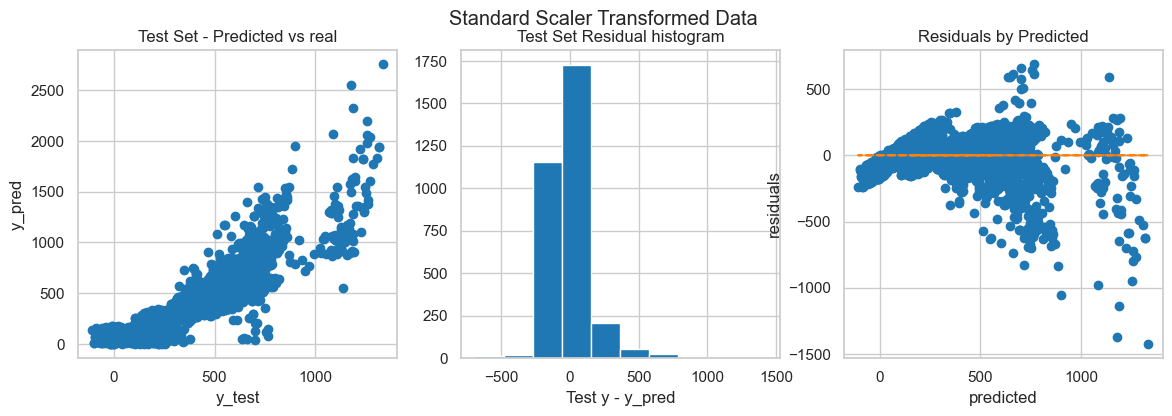

In [82]:
# PLOTS FOR STANDARD SCALER TRANSFORMED DATA
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
fig.suptitle("Standard Scaler Transformed Data")
ax[0].plot(y_pred_ct, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscedasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred_ct)
ax[1].set_xlabel("Test y - y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred_ct,y_pred_ct.to_numpy() - y_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_ct,np.zeros(len(y_pred_ct)),linestyle='dashed')
plt.show()

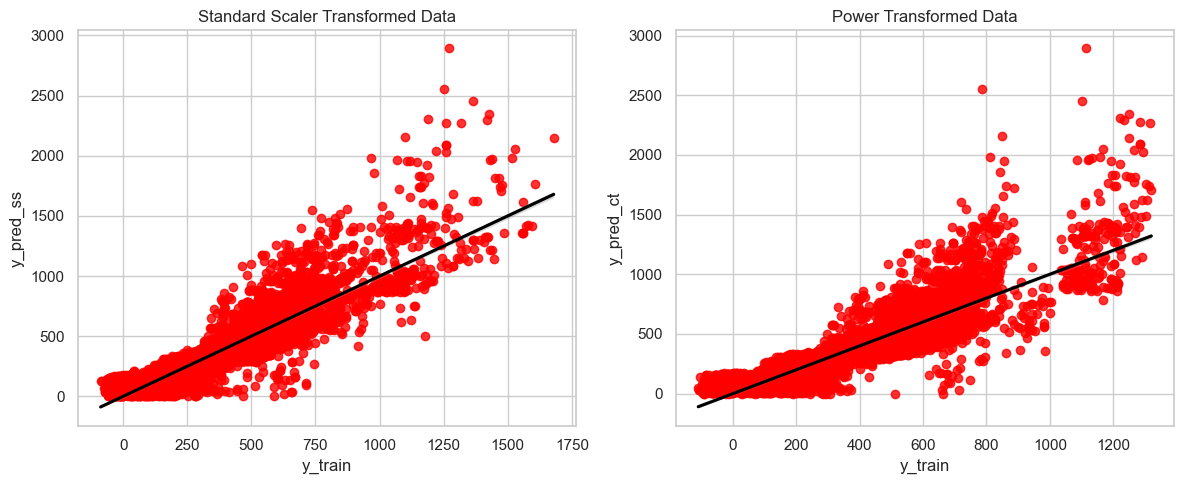

In [83]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first distribution
sns.regplot(x=y_pred_train_ss,y=y_train,scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=ax[0])
ax[0].set_title("Standard Scaler Transformed Data")
ax[0].set_xlabel('y_train')
ax[0].set_ylabel('y_pred_ss')
# Plot the second distribution
sns.regplot(x=y_pred_train_ct,y=y_train,scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=ax[1])
ax[1].set_title("Power Transformed Data")
ax[1].set_xlabel('y_train')
ax[1].set_ylabel("y_pred_ct")

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


## checking errors for power transformed data

### MSE

In [84]:
# of the real y vs. the predicted y
mse_test_pred_ct = mse(y_test,y_pred_ct)
# prediction on the train set
mse_train_pred_ct = mse(y_train,y_pred_train_ct)
print(mse_test_pred_ct, mse_train_pred_ct)

23564.34575372819 22116.82202136159


### RMSE

In [85]:
rmse_test_pred_ct = math.sqrt(mse_test_pred_ct)
rmse_train_pred_ct = math.sqrt(mse_train_pred_ct)
print(rmse_test_pred_ct, rmse_train_pred_ct)

153.5068264075842 148.71725529124583


### MAE

In [86]:
mae_ss = mae(y_test,y_pred_ct)

### R2

In [87]:
r2_test_pred_ct = r2_score(y_test,y_pred_ct)
r2_train_pred_ct = r2_score(y_train,y_pred_train_ct)
print(r2_test_pred_ct, r2_train_pred_ct)

0.7297860074617714 0.7394082853116619


### adjusted R2

In [88]:
n = X.shape[0]
p = X.shape[1]
r2_a_ct = 1-(1-r2_train_pred_ct)*(n-1)/(n-p-1)
r2_a_ct

0.7383064693611803

## checking errors for standard scaler transformed data

### MSE

In [89]:
# of the real y vs. the predicted y
mse_test_pred_ss = mse(y_test,y_pred_ss)
# prediction on the train set
mse_train_pred_ss = mse(y_train,y_pred_train_ss)
print(mse_test_pred_ss, mse_train_pred_ss)

20685.276564406435 19177.79619088357


### RMSE

In [90]:
rmse_test_pred_ss = math.sqrt(mse_test_pred_ss)
rmse_train_pred_ss = math.sqrt(mse_train_pred_ss)
print(rmse_test_pred_ss, rmse_train_pred_ss)

143.82376912181948 138.48392033331368


### MAE

In [91]:
mae_ct = mae(y_test,y_pred_ss)

### R2

In [92]:
r2_test_pred_ss = r2_score(y_test,y_pred_ss)
r2_train_pred_ss = r2_score(y_train,y_pred_train_ss)
print(r2_test_pred_ss, r2_train_pred_ss)

0.7628004942025013 0.7740373916063117


### adjusted R2

In [93]:
n = X.shape[0]
p = X.shape[1]
r2_a_ss = 1-(1-r2_train_pred_ss)*(n-1)/(n-p-1)
r2_a_ss

0.7730819920594061

## Feature importance

In [98]:
features_importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': abs(model_ct.coef_.reshape(len(X.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
23,personal l3,1.984688e+15
17,personal auto,1.786308e+15
22,personal l2,1.725197e+15
21,personal l1,1.413287e+15
18,special auto,1.031760e+15
25,special l2,6.826210e+14
26,special l3,6.460214e+14
24,special l1,4.586324e+14
13,suburban,1.839569e+02
40,monthly_premium_auto,9.780711e+01


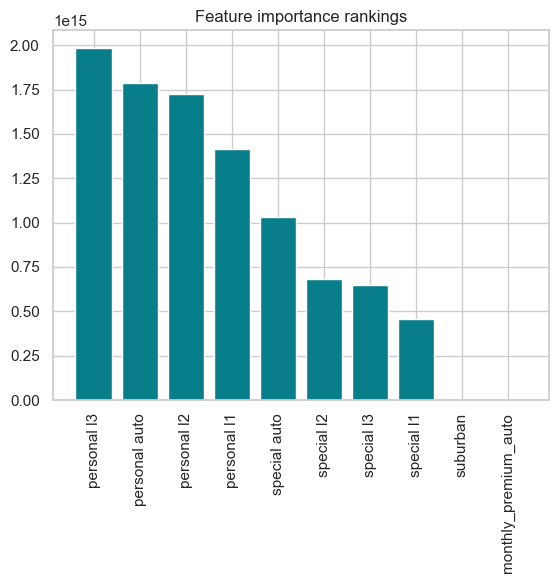

In [99]:
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='vertical')
plt.show()

# comparison standard scaler and power transform

In [104]:
# make an overview comparison between SS and PT
ss_vs_ct = pd.DataFrame(
    { "StandardScaler" : { "MSE_test" : mse_test_pred_ss,
                           "MSE_train" : mse_train_pred_ss,
                           "RMSE_test" : rmse_test_pred_ss,
                           "RMSE_train" : rmse_test_pred_ss,
                           "MAE" : mae_ss,
                           "R2" : r2_train_pred_ss,
                           "adjusted R2" : r2_a_ss
                           } ,
      "Power Transformer" : { "MSE_test" : mse_test_pred_ct,
                           "MSE_train" : mse_train_pred_ct,
                           "RMSE_test" : rmse_test_pred_ct,
                           "RMSE_train" : rmse_test_pred_ct,
                           "MAE" : mae_ct,
                           "R2" : r2_train_pred_ct,
                           "adjusted R2" : r2_a_ct
                              }
      } )
ss_vs_ct.to_csv("Comparison_of_scalers_including_categorical_and_numerical.csv")

In [105]:
ss_vs_ct

,StandardScaler,Power Transformer
MSE_test,20685.276564,23564.345754
MSE_train,19177.796191,22116.822021
RMSE_test,143.823769,153.506826
RMSE_train,143.823769,153.506826
MAE,103.959651,97.913642
R2,0.774037,0.739408
adjusted R2,0.773082,0.738306


In [106]:
num_errors = pd.read_csv("Comparison_of_scalers_numerical.csv")

In [107]:
complete_errors = pd.read_csv("Comparison_of_scalers_including_categorical_and_numerical.csv")

TypeError: cannot unpack non-iterable AxesSubplot object

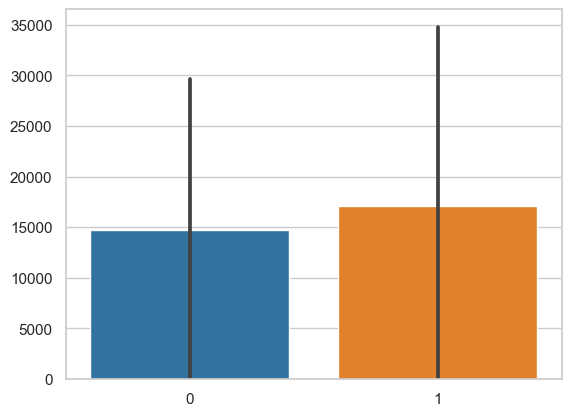

In [114]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first distribution
sns.barplot(x=ss_vs_ct.index[1],y=ss_vs_ct["StandardScaler"][1], ax=ax[0])
ax[0].set_title("Standard Scaler Transformed Data")
ax[0].set_xlabel('y_train')
ax[0].set_ylabel('y_pred_ss')

In [1]:
X

NameError: name 'X' is not defined